In [2]:
#imports and settings
import pandas as pd, numpy as np, matplotlib.pylab as plt, seaborn as sns
from scipy.integrate import quad
from sklearn.neighbors import BallTree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import seaborn as sns

sns.set(style="darkgrid")
%matplotlib inline 
#%matplotlib notebook makes the charts interactive

In [3]:
#project-specific constants
howmanypols=5000
min_age_entry,max_age_entry=18,65
min_dur,max_dur=4,7
#choose the dimensions to group by
dims=['dur','age']
clustrs=140 #chosen to be a similar number as the number of unit bins in 4 to 7 x 18 to 65

In [4]:
#generate a force of lapse function and integrate it across duration
#integration is more accurate but the integration is done in very small increments
#could equally have approximated using Euler's method
a,b,s,sc1,sc2,basemu=5.3,5.7,0.05,0.15,0.15,0.15

def mu(x):
    return basemu+sc1*np.exp(-(((x-a))**2)/s)-sc2*np.exp(-(((x-b))**2)/s)

In [5]:
mu_intg_tbl=pd.DataFrame({'dur':np.arange(0,max_dur+1,0.01)}) #max_dur+1 to ensure the lookup goes high enough
for i in mu_intg_tbl.index:
    mu_intg_tbl.loc[i,'intg']=quad(mu,0,mu_intg_tbl.dur[i])[0] 
    #use only the first result from quad; the second one is a precision estimate

Generate some random policies, before allowing for lapses

In [6]:
#to bypass the vagaries of the Gregorian calendar for the purpose of an example, 
#pretent that all time-based labels change in even steps of 0.01

np.random.seed(0) #we want reproducible results so initialise pseudo-random numbers with a fixed state
pdata=pd.DataFrame({'rnd1':np.random.rand(howmanypols),'rnd2':np.random.rand(howmanypols),'rnd3':np.random.rand(howmanypols)})
pdata['entry_age']=(min_age_entry+(max_age_entry-min_age_entry)*pdata.rnd1).round(2)
pdata['id']=pdata.index.astype('str')
pdata['dur_frm'],pdata['dur_upto']=min_dur,max_dur #analysis will be up to and including dur_upto

To get the simulated duration at surrender, use a random number R3 that is uniform between 0 and 1. 

Using the inverse cumulative distribution method, find the largest t such that the probability of lapse having happened by time t, given not yet lapsed at the start duration s, is not less than R3. 
For convenience use 1-R3 instead of R3 because their distribution is the same.
The cumulative distribution function is the probability that the policy will lapse between time s and time t. This is given by 1-exp(-{integral of mu(x) between s and t})

Putting this together, find t such that:
1-R3=1-exp(-{integral of mu(x) between s and t})

=>-ln(R3)={integral of mu(x) between s and t}={integral of mu(x) between 0 and t}-{integral of mu(x) between 0 and s}

=>{integral of mu(x) between 0 and s}-ln(R3)={integral of mu(x) between 0 and t}

So, calculate {integral of mu(x) between 0 and s}-ln(R3), find the corresponding integral value and return its duration

In [7]:
#look up the integral between 0 and s. merge likes integers hence the *100.
pdata['dur_frm100']=(pdata.dur_frm*100).astype('int')
mu_intg_tbl['dur_frm100']=mu_intg_tbl.index.astype('int')
pdata['mu_intg_dur_frm']=pd.merge(pdata,mu_intg_tbl,on='dur_frm100',how='left')[['intg']]
#create the lapse lookup value to compare against the integral table
pdata['lps_lkp']=pdata.mu_intg_dur_frm-np.log(pdata.rnd3)
pdata=pdata.sort_values(by='lps_lkp').reset_index() #reset index is needed for merge_asof

#do a merge_asof to find the largest value in the integral table that is not smaller than lps_lkp, then return the corresponding duration
pdata['l_dur']=pd.merge_asof(pdata[['lps_lkp']],mu_intg_tbl,left_on='lps_lkp',right_on='intg')[['dur']]

#lapse durations after the end of the investigation are not needed; investigation only up to lapse if there is one
pdata.loc[pdata.l_dur>=pdata.dur_upto,'l_dur']=np.nan
pdata.loc[pdata.l_dur<pdata.dur_upto,'dur_upto']=pdata.l_dur

In [8]:
#clear out intermediary columns
pdata=pdata.drop(columns=['dur_frm100','mu_intg_dur_frm','lps_lkp','index','rnd1','rnd2','rnd3'])

In [9]:
decs=pdata[pd.notnull(pdata.l_dur)].reset_index(drop=True).rename(columns={'l_dur':'dur'})
decs['age']=(decs.entry_age+decs.dur).round(2)
decs['decid']=decs.index #used in merge later

Consider normalizing data at this step, for example if using a combination of money and time dimensions. Will not normalize here because one year is the same length for age and duration.

In [10]:
p=pdata[['dur_frm','dur_upto','entry_age']]
elist=[]
#Generate the exposure
for n in p.index: #need to iterate across the index; slow but necessary
    pn=p[p.index==n]
    t=pd.DataFrame({'dur':range(int(pn.iloc[0,0]*100),int(pn.iloc[0,1]*100+1))}) 
    #+1 because the last day should also be counted in the range
    t.dur=t.dur/100
    t['age']=(t.dur+pn.iloc[0,2]).round(2) #current duration + entry age
    elist.append(t)

In [11]:
e=pd.concat(elist).reset_index(drop=True) #could also do the concat in phases to save memory
e['ageint'],e['durint']=e.age.apply(np.floor),e.dur.apply(np.floor)

In [12]:
tree=BallTree(decs[dims],15) #by default, the distance metric is minkowski with p=2, aka Euclidean
#query nearest distances
ee=e[dims].copy()
dy,ee['indices']=tree.query(ee,1) #dy is a dummy to catch the distances which are not needed here

In [13]:
ee['eu']=ee.index #eu is exposure units
af,vs={'eu':'count'},['eu']
for dim in dims: #generate the items to pivot and aggregate by
    af[dim]='sum'
    vs.append(dim)
piv=pd.pivot_table(ee,index='indices',values=vs,aggfunc=af).reset_index()

In [14]:
for w in dims:
    piv['a_'+w]=piv[w]/piv.eu

piv['m_l']=100/piv.eu
piv=piv.sort_values(by='m_l',ascending=True)

<AxesSubplot:xlabel='a_dur', ylabel='m_l'>

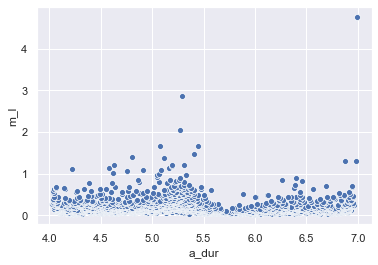

In [15]:
sns.scatterplot(piv.a_dur,piv.m_l)

In [16]:
fitlist=['a_'+i for i in dims]

In [17]:
k_means=KMeans(init='k-means++',n_clusters=clustrs,n_init=12)
fitlist=['a_'+i for i in dims]
fl2=fitlist.copy()
fl2.append('m_l')
k_means.fit(piv[fl2])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=140, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
piv['lbl']=k_means.labels_

In [19]:
#tie the clustered labels back to the original data
ee['lbl']=pd.merge(ee,piv,how='left',on='indices')[['lbl']]
decs['lbl']=pd.merge(decs.decid,piv[['indices','lbl']],how='left',left_on='decid',right_on='indices')[['lbl']]
#decs=decs.sort_values(by=['lbl','decid'])
decs['cs']=decs.decid.groupby(decs.lbl).transform('cumsum')/decs.decid.groupby(decs.lbl).transform('sum')
ee['cs']=pd.merge(ee,decs,how='left',left_on='indices',right_on='decid')[['cs']]

In [20]:
#set up some colours
color_labels=piv.lbl.unique()
rgb_values=sns.color_palette("Set2", 4)
color_map=dict(zip(color_labels, rgb_values))

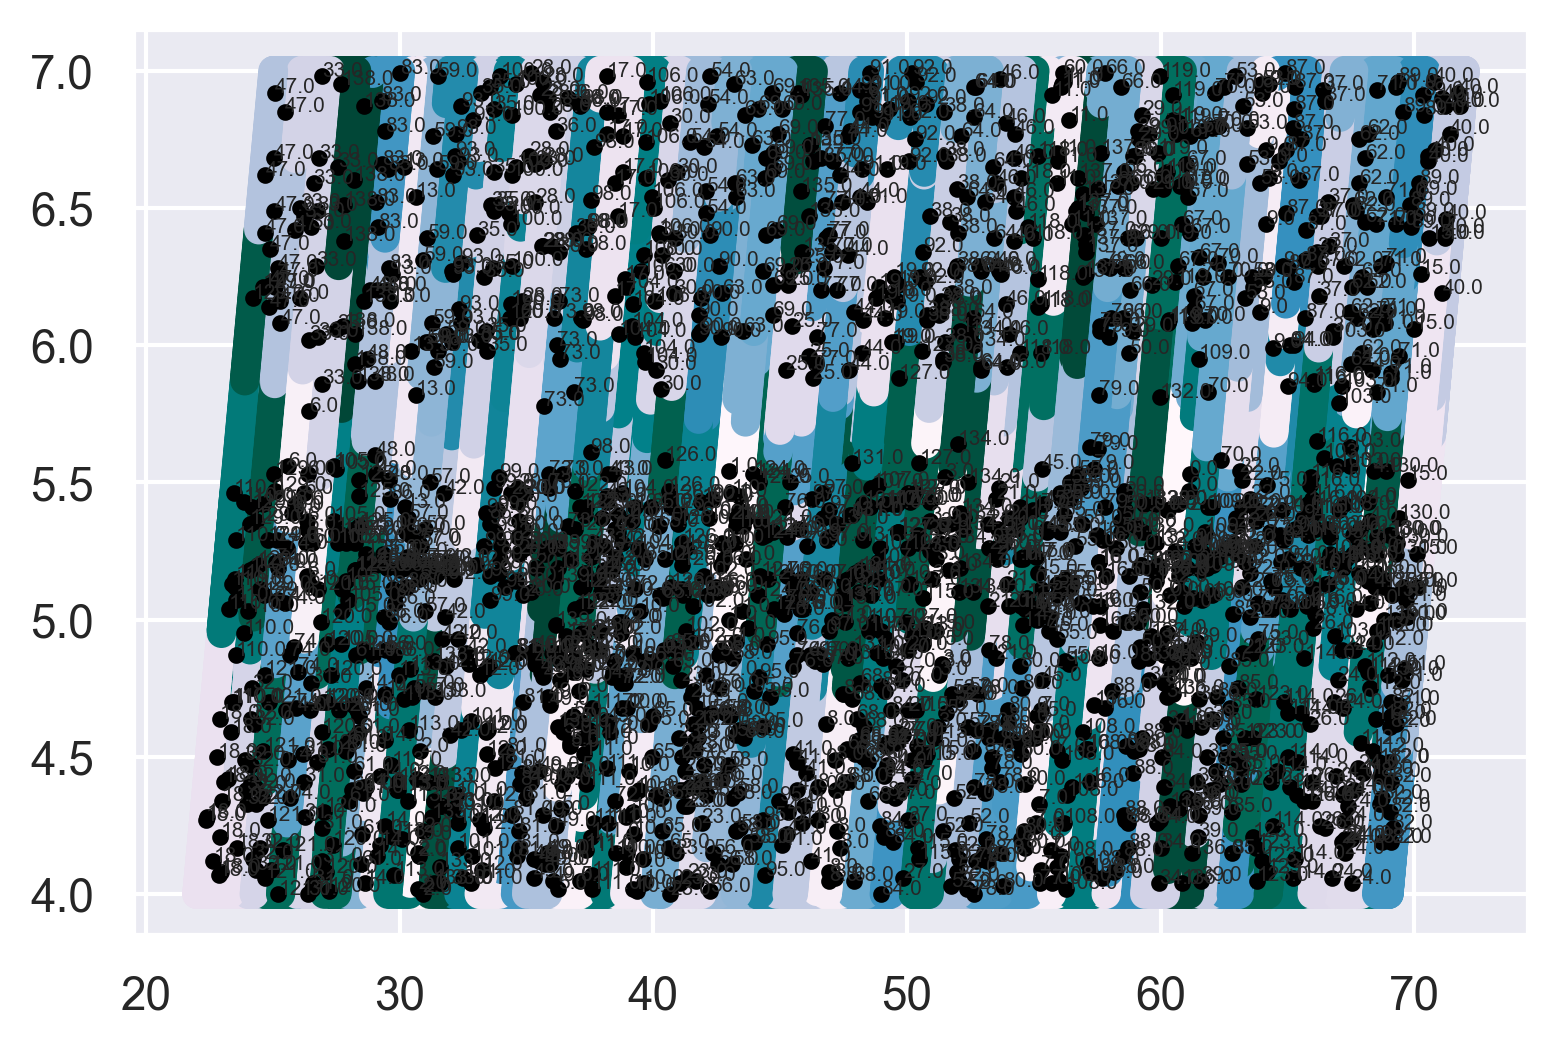

In [21]:
fig=plt.figure(dpi=300)
cmapchooser=15
cc=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
             'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
ee_sel,dec_sel=ee,decs
plt.scatter(ee_sel.age,ee_sel.dur,c=ee_sel.lbl,cmap=cc[cmapchooser])
for i in dec_sel.index:
    plt.annotate(str(dec_sel.lbl[i]),(dec_sel.age[i], dec_sel.dur[i]),fontsize=5)
plt.scatter(dec_sel.age,dec_sel.dur,marker='.',c='black')
plt.savefig('plt_all.png')

Choose 63 and 69 as neighbours to highlight

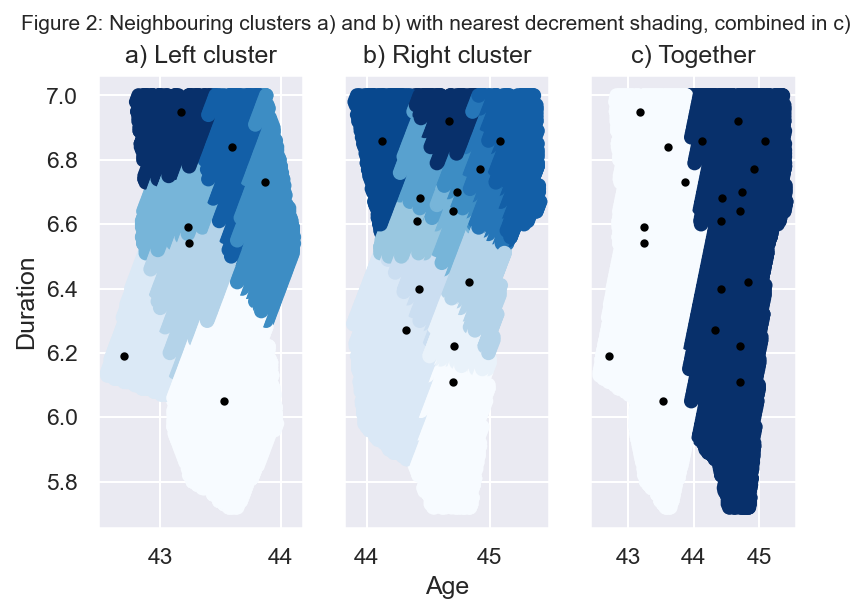

In [38]:
schemes1=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
fig,(ax1,ax2,ax3)=plt.subplots(1,3,sharey=True,dpi=150)
fig.suptitle('Figure 2: Neighbouring clusters a) and b) with nearest decrement shading, combined in c)',fontsize=10)

cmapchooser=2
lblchooser=set([63])
ee_sel,dec_sel=ee[ee.lbl.isin(lblchooser)],decs[decs.lbl.isin(lblchooser)]
ax1.set(ylabel='Duration')
ax1.scatter(ee_sel.age,ee_sel.dur,c=ee_sel.cs,cmap=schemes1[cmapchooser])
ax1.scatter(dec_sel.age,dec_sel.dur,marker='.',c='black')
ax1.set_title('a) Left cluster')

lblchooser=set([69])
ee_sel,dec_sel=ee[ee.lbl.isin(lblchooser)],decs[decs.lbl.isin(lblchooser)]
ax2.set(xlabel='Age')
ax2.scatter(ee_sel.age,ee_sel.dur,c=ee_sel.cs,cmap=schemes1[cmapchooser])
ax2.scatter(dec_sel.age,dec_sel.dur,marker='.',c='black')
ax2.set_title('b) Right cluster')

cmapchooser=2
lblchooser=set([63,69])
ee_sel,dec_sel=ee[ee.lbl.isin(lblchooser)],decs[decs.lbl.isin(lblchooser)]
ax3.scatter(ee_sel.age,ee_sel.dur,c=ee_sel.lbl,cmap=schemes1[cmapchooser])
ax3.scatter(dec_sel.age,dec_sel.dur,marker='.',c='black')
ax3.set_title('c) Together')
plt.savefig('Figure2.png')
plt.show()

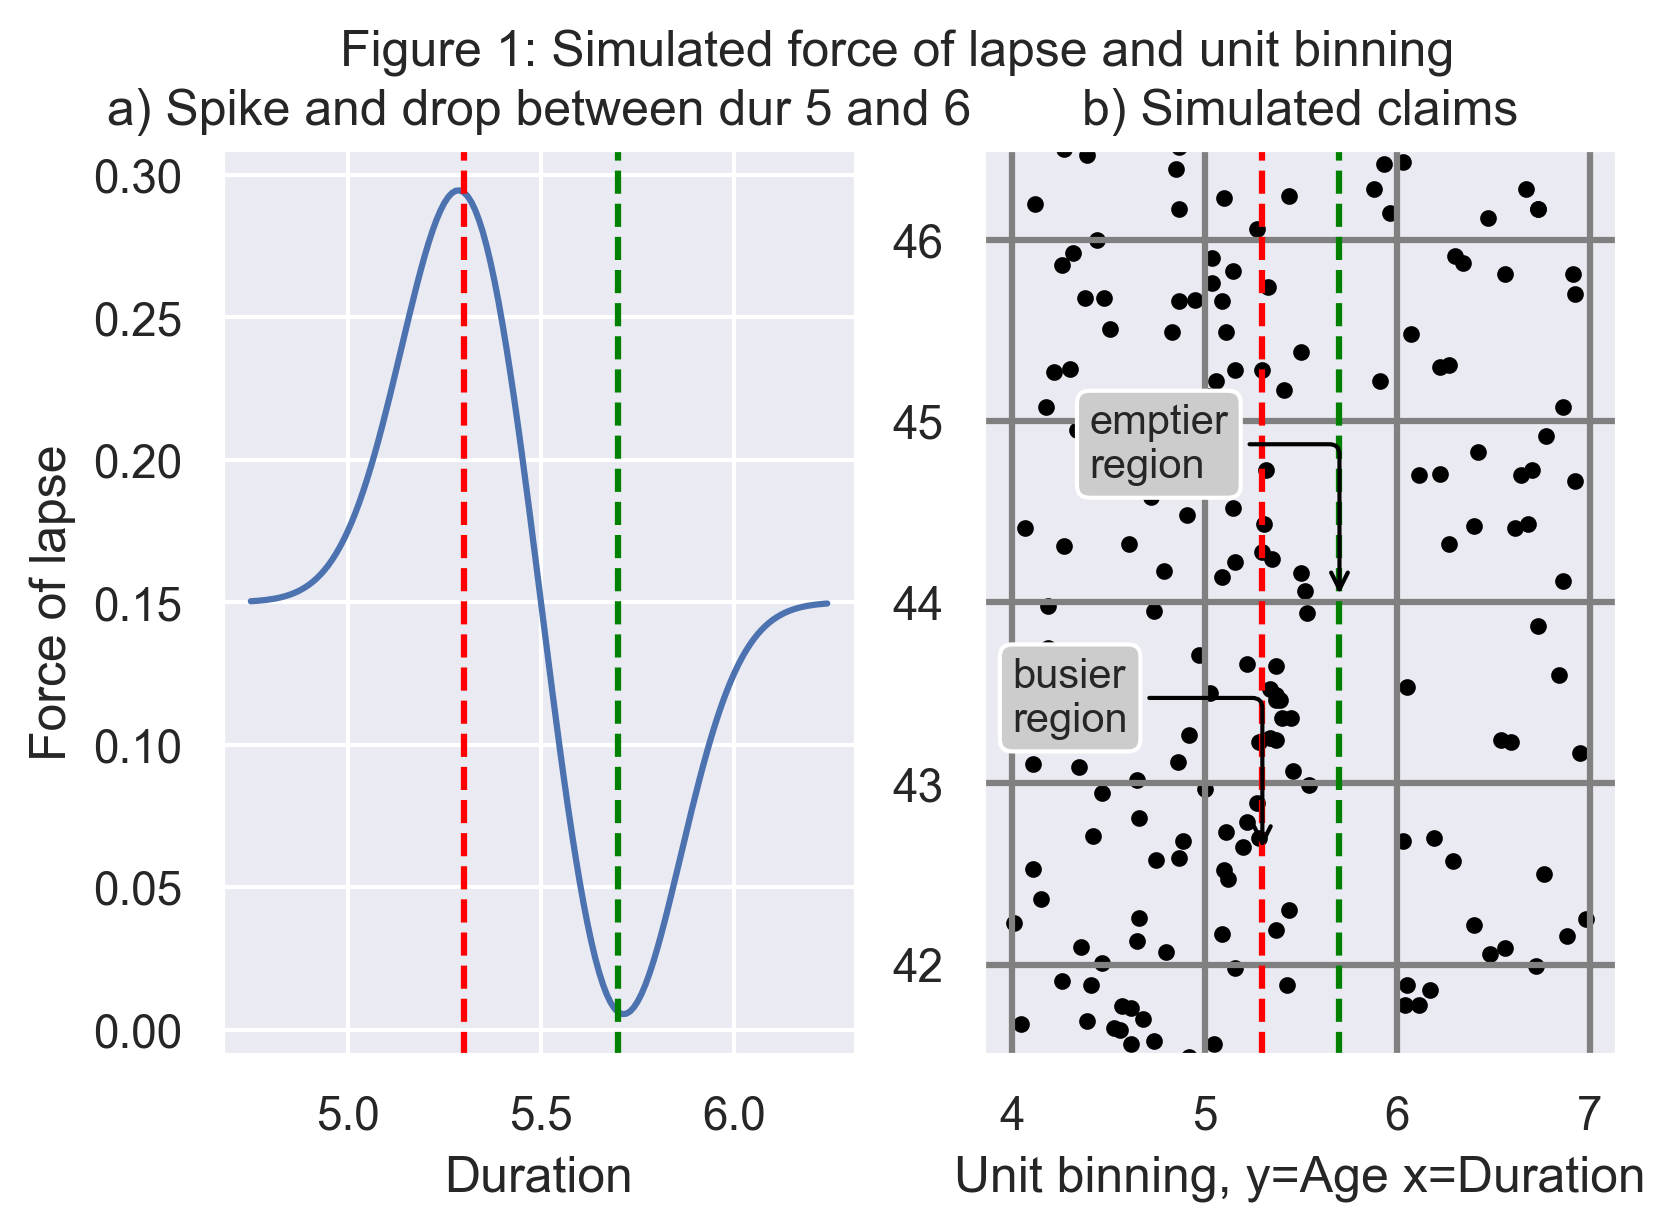

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,dpi=300)
fig.suptitle('Figure 1: Simulated force of lapse and unit binning')
#plot the key range of the mu function
x=np.arange(4.75,6.25,0.01)
ax1.plot(x,mu(x))
ax1.axvline(x=5.3,c='red',ls='--')
ax1.axvline(x=5.7,c='green',ls='--')
ax1.set_title('a) Spike and drop between dur 5 and 6')
ax1.set(xlabel='Duration')
ax1.set(ylabel='Force of lapse')

ax2.set_ylim([41.5,46.5])
ax2.set_title('b) Simulated claims')
dec_sel=decs
ax2.scatter(dec_sel.dur,dec_sel.age,marker='.',c='black')
for i in range(21,73):
    ax2.axhline(y=i,c='grey')
for i in range(4,8):
    ax2.axvline(x=i,c='grey')
ax2.axvline(x=5.3,c='red',ls='--')
ax2.axvline(x=5.7,c='green',ls='--')
ax2.set(xlabel='Unit binning, y=Age x=Duration')
#ax2.set(ylabel='Age')                          

ax2.annotate('emptier\nregion',
            xy=(5.7,44), xycoords='data',
            xytext=(-60, 30), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10",color='black'))

ax2.annotate('busier\nregion',
            xy=(5.3,42.6), xycoords='data',
            xytext=(-60, 30), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10",color='black'))

plt.savefig('Figure1.png')
plt.show()